### Import modules

In [1]:
# Standard imports
import pandas as pd
import sys 
import os
import numpy as np
import matplotlib
from matplotlib.patches import Arc
import seaborn as sns
from matplotlib.cm import ScalarMappable
import os
import shutil
import matplotlib.pyplot as plt
# Apply better style
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3, 'axes.linewidth': 0.3})

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

# retina plot
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 150

In [2]:
df_sim_1 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000/output_particles.parquet")
df_sim_2 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000_repr/output_particles.parquet")

# Rename column x to x_init and y to y_init
df_sim_1 = df_sim_1.rename(columns={"x": "x_final", "y": "y_final"})
df_sim_2 = df_sim_2.rename(columns={"x": "x_final", "y": "y_final"})


df_particle_1 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000/particles/00.parquet")
df_particle_2 = pd.read_parquet("/home/HPC/cdroin/DA_statistics_GPU/studies/scans/statistics_eol_massive/base_collider/xtrack_0000_repr/particles/00.parquet")

df_sim_1 = pd.merge(df_sim_1, df_particle_1, on=["particle_id"])
df_sim_1 = df_sim_1[['at_turn', 'state', "x", "y"]]

df_sim_2 = pd.merge(df_sim_2, df_particle_2, on=["particle_id"])
df_sim_2 = df_sim_2[['at_turn', 'state', "x", "y"]]

# Concatenate both df
df_sim = pd.concat([df_sim_1, df_sim_2], ignore_index = True)


df_sim_survived = df_sim[df_sim['state'] == 1]
df_sim_lost = df_sim[df_sim['state'] != 1]

In [3]:
df_sim_survived

,at_turn,state,x,y
0,1000000,1,0.065000,6.047210
2,1000000,1,5.219076,4.349955
3,1000000,1,6.280092,4.101040
5,1000000,1,3.519543,1.562563
8,1000000,1,0.969411,5.744472
...,...,...,...,...
39991,1000000,1,1.011020,4.027095
39992,1000000,1,1.315820,5.969868
39994,1000000,1,2.583846,5.835579
39995,1000000,1,6.676763,1.782370


In [4]:
df_sim_lost

,at_turn,state,x,y
1,105525,-1,7.826189,3.208923
4,172549,-1,5.544025,6.957659
6,31831,-1,8.349919,2.716581
7,811878,-1,3.441855,6.392799
9,621213,-1,6.518374,2.865090
...,...,...,...,...
39990,209856,-1,3.756734,7.102857
39993,188295,-1,5.730223,6.681806
39997,53216,-1,5.445909,6.873581
39998,50323,-1,8.712513,2.247131


In [5]:
# Add a column with amplitude
df_sim_survived.loc[:,"amplitude"] = np.sqrt(df_sim_survived["x"]**2 + df_sim_survived["y"]**2)
df_sim_lost.loc[:,"amplitude"] = np.sqrt(df_sim_lost["x"]**2 + df_sim_lost["y"]**2)

/tmp/ipykernel_28776/1119540019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim_survived.loc[:,"amplitude"] = np.sqrt(df_sim_survived["x"]**2 + df_sim_survived["y"]**2)
/tmp/ipykernel_28776/1119540019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim_lost.loc[:,"amplitude"] = np.sqrt(df_sim_lost["x"]**2 + df_sim_lost["y"]**2)


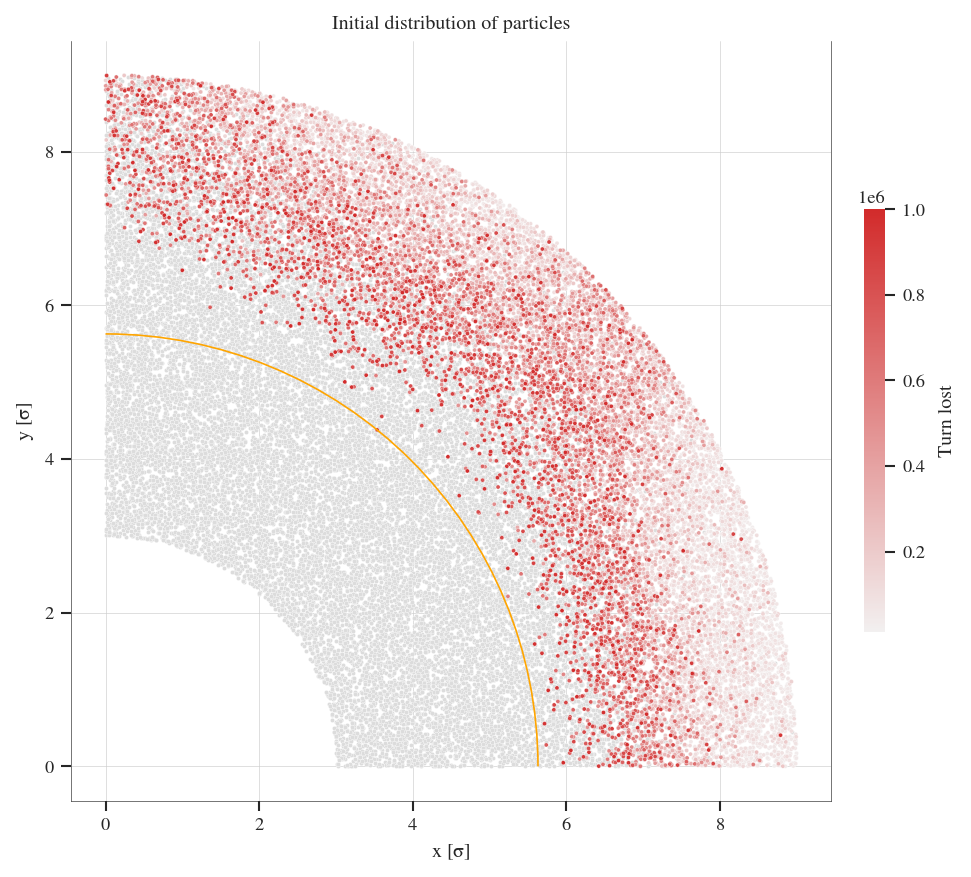

In [10]:
# Plot initial distribution of particles
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
norm = plt.Normalize(df_sim["at_turn"].min(), df_sim["at_turn"].max())
sm = sns.light_palette("#D22B2B", as_cmap=True)
cmappable = ScalarMappable(norm=norm, cmap=sm)

sns.scatterplot(data=df_sim_survived, x="x", y="y", color = 'gainsboro', ax=ax, s=4)
sns.scatterplot(data=df_sim_lost, x="x", y="y", hue=df_sim_lost["at_turn"], palette = sm, ax=ax, s=4)
ax.set_xlabel(r"x [$\sigma$]")
ax.set_ylabel(r"y [$\sigma$]")
ax.set_title("Initial distribution of particles")
ax.get_legend().remove()
cbar = ax.figure.colorbar(cmappable, ax=ax, fraction=0.026, pad=0.04)
cbar.ax.set_ylabel("Turn lost", rotation=90, va="bottom", labelpad=15)
cbar.outline.set_visible(False)

# Add DA to plot
DA = np.min(df_sim_lost["amplitude"])
arc = Arc((0, 0), 2*DA, 2*DA, color='orange', theta1=0, theta2=90)
ax.add_patch(arc)
ax.set_aspect('equal', adjustable='box')

plt.grid(visible=None)
plt.show()

In [7]:

### Get minimum amplitude of particles lost as n_turn increases
df_sim_lost = df_sim_lost.sort_values(by="at_turn")
temp_amplitude = 1000
for idx, row in df_sim_lost.iterrows():
    if df_sim_lost.loc[idx, 'amplitude'] < temp_amplitude:
        temp_amplitude = df_sim_lost.loc[idx, 'amplitude']
    df_sim_lost.loc[idx, 'min_amplitude'] = temp_amplitude
    
### Compute the percentage of particles lost
tot_part = len(df_sim)
df_sim_lost['percent_lost'] = df_sim_lost['at_turn'].apply(lambda x: len(df_sim_lost[df_sim_lost['at_turn'] <= x])/tot_part*100)


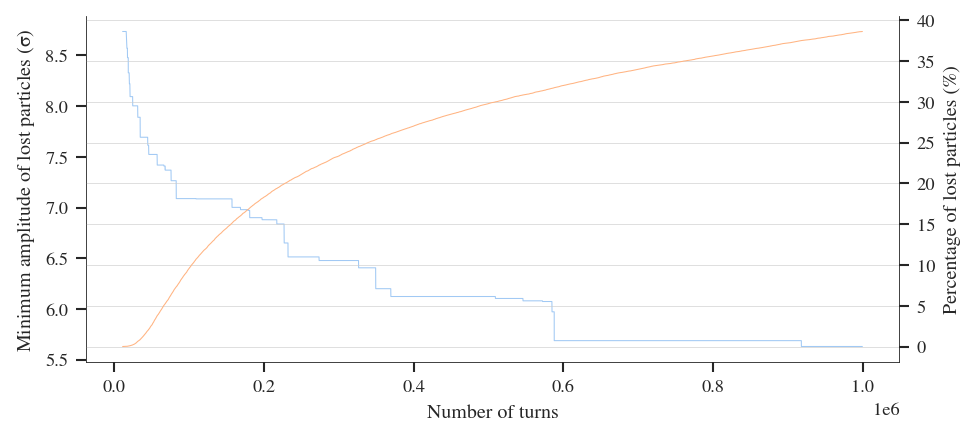

In [9]:
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3, 'axes.linewidth': 0.3})

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"


# Plot evolution of minimum amplitude of particles lost and number of particles lost vs number of turns
# Do the plot with each lineplot having its own y-axis
l_colors = sns.color_palette("pastel")

fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()
sns.lineplot(data=df_sim_lost[:], x="at_turn", y="min_amplitude", ax=ax1, color=l_colors[0])
sns.lineplot(data=df_sim_lost[:], x="at_turn", y="percent_lost", ax=ax2, color=l_colors[1])
ax1.set_xlabel("Number of turns")
ax1.set_ylabel(r"Minimum amplitude of lost particles ($\sigma$)")
ax2.set_ylabel("Percentage of lost particles (%)")
#ax1.set_title("Minimum amplitude of lost particles and percentage of lost particles vs number of turns")
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
plt.grid()
plt.show()



